In [1]:
import tensorflow as tf
from glob import glob
import os
import cv2
from PIL import Image
from tensorflow.keras.utils import normalize
import numpy as np



2022-01-25 21:19:32.936275: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
img_dataset = []
msk_dataset = []

f_img = sorted(glob('dataset/train/asagao/*'))
for f in f_img:
    image = cv2.imread(f)
    # image = image.resize((SIZE, SIZE))
    #Nomalize an image from 0-255 to 0 - 1
    image = image.astype('float32') / 255.0
    img_dataset.append(np.array(image))

f_msk = sorted(glob('dataset/validation/asagao/*'))
for f in f_msk:
    image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]
    # image = Image.fromarray(image)
    # image = image.resize((SIZE, SIZE))
    msk_dataset.append(np.array(image))

# img_dataset = (img_dataset - v_min)/(v_max - v_min)
# print(img_dataset.shape)
# #Normalize images
# img_dataset = normalize(np.array(img_dataset), axis=1) #wrong normalization




In [3]:
asagao_dataset = np.array(img_dataset)
# img_dataset = np.array(img_dataset)
# #D not normalize masks, just rescale to 0 to 1.a
asagao_msk_dataset = np.expand_dims(np.array(msk_dataset) /255., -1)

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(asagao_dataset, asagao_msk_dataset, test_size= 0.10, random_state=0)
# y_train = to_categorical(y_train, 3)

### DATA SANITY CHECK

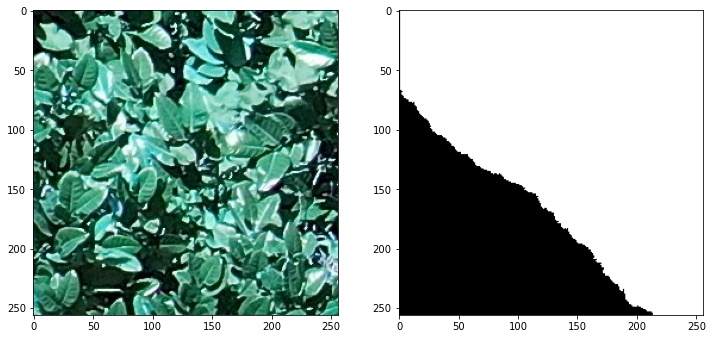

In [37]:
import random
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
X_train_quick_test, X_test_quick_test, y_train_quick_test, y_test_quick_test = train_test_split(X_train, y_train, test_size = 0.9, random_state = 0)
image_number = random.randint(0, len(X_train_quick_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train_quick_test[image_number], (256, 256,3)))
plt.subplot(122)
plt.imshow(np.reshape(y_train_quick_test[image_number], (256, 256,1)), cmap='gray')
plt.show()

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout,Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
    
# model.summary()
input_w = 256
input_h = 256
input_ch = 3

s  = Input((input_w, input_h, input_ch))
#Downscale path -----------------------------------------------------------------------------------
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)
#100
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)
#50
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
#15
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Scale up path ----------------------------------------------------------------------------------
u6 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
model = Model(inputs=[s], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2022-01-25 21:20:48.301794: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-25 21:20:48.304866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-25 21:20:48.505289: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-25 21:20:48.505345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.755GHz coreCount: 30 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 312.97GiB/s
2022-01-25 21:20:48.505363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-25 21:20:48.527001: I tensorflow/stream_executor/platfo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

### train with asagao pixel

In [40]:
history = model.fit(X_train, 
                    y_train,
                    verbose = 1,
                    batch_size = 16,
                    epochs = 40,
                    validation_data = (X_test, y_test),
                    shuffle = False)
model.save("50m_30m_Unet")

2022-01-25 21:20:59.038910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-25 21:20:59.041405: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3800010000 Hz


Epoch 1/40


2022-01-25 21:20:59.811138: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-01-25 21:21:00.968993: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-01-25 21:21:00.990496: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-01-25 21:21:01.431123: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


16/16 [==============================] - 45s 2s/step - loss: 0.6958 - accuracy: 0.4910 - val_loss: 0.6838 - val_accuracy: 0.6098
Epoch 2/40
16/16 [==============================] - 2s 125ms/step - loss: 0.6772 - accuracy: 0.6063 - val_loss: 0.6583 - val_accuracy: 0.6058
Epoch 3/40
16/16 [==============================] - 2s 123ms/step - loss: 0.6402 - accuracy: 0.6334 - val_loss: 0.6338 - val_accuracy: 0.6248
Epoch 4/40
16/16 [==============================] - 2s 123ms/step - loss: 0.6227 - accuracy: 0.6404 - val_loss: 0.6251 - val_accuracy: 0.6356
Epoch 5/40
16/16 [==============================] - 2s 123ms/step - loss: 0.6142 - accuracy: 0.6483 - val_loss: 0.6179 - val_accuracy: 0.6390
Epoch 6/40
16/16 [==============================] - 2s 121ms/step - loss: 0.6045 - accuracy: 0.6596 - val_loss: 0.6252 - val_accuracy: 0.6388
Epoch 7/40
16/16 [==============================] - 2s 121ms/step - loss: 0.6083 - accuracy: 0.6621 - val_loss: 0.5970 - val_accuracy: 0.6752
Epoch 8/40
16/16 [=

2022-01-25 21:22:59.378604: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: 50m_30m_Unet/assets


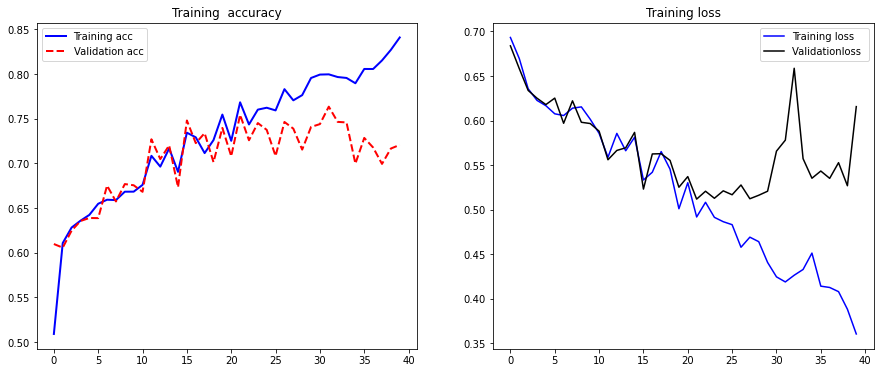

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc',linewidth=2)
plt.plot(epochs, val_acc, 'r--', label='Validation acc',linewidth=2)
plt.title('Training  accuracy')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'b', label='Training loss')

plt.plot(epochs, val_loss, 'k', label='Validationloss ')
plt.title('Training loss')
plt.legend()

plt.show()

In [42]:
##################################
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.6

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.5632003681402344


### train with non-asagao


In [43]:
non_asagao_dataset = []
non_asagao_msk_dataset = []

f_img = sorted(glob('dataset/non_asagao_train/*'))
for f in f_img:
    image = cv2.imread(f)
    # image = image.resize((SIZE, SIZE))
    #Nomalize an image from 0-255 to 0 - 1
    image = image.astype('float32') / 255.0
    img_dataset.append(np.array(image))

f_msk = sorted(glob('dataset/non_asagao_validation/*'))
for f in f_msk:
    image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]
    # image = Image.fromarray(image)
    # image = image.resize((SIZE, SIZE))
    msk_dataset.append(np.array(image))


In [46]:
non_asagao_dataset = np.array(img_dataset)
# img_dataset = np.array(img_dataset)
# #D not normalize masks, just rescale to 0 to 1.a
non_asagao_msk_dataset = np.expand_dims(np.array(msk_dataset) /255., -1)

In [47]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(non_asagao_dataset, non_asagao_msk_dataset, test_size= 0.20, random_state=0)
# y_train = to_categorical(y_train, 3)

In [48]:
history = model.fit(X_train, 
                    y_train,
                    verbose = 1,
                    batch_size = 16,
                    epochs = 40,
                    validation_data = (X_test, y_test),
                    shuffle = False)
model.save("50m_30m_Unet")

Epoch 1/40
14/14 [==============================] - 13s 975ms/step - loss: 0.3164 - accuracy: 0.8627 - val_loss: 0.4768 - val_accuracy: 0.7938
Epoch 2/40
14/14 [==============================] - 2s 129ms/step - loss: 0.2853 - accuracy: 0.8806 - val_loss: 0.4755 - val_accuracy: 0.7977
Epoch 3/40
14/14 [==============================] - 2s 129ms/step - loss: 0.2518 - accuracy: 0.8993 - val_loss: 0.5065 - val_accuracy: 0.7905
Epoch 4/40
14/14 [==============================] - 2s 129ms/step - loss: 0.2164 - accuracy: 0.9168 - val_loss: 0.5373 - val_accuracy: 0.8026
Epoch 5/40
14/14 [==============================] - 2s 128ms/step - loss: 0.1895 - accuracy: 0.9261 - val_loss: 0.5794 - val_accuracy: 0.8044
Epoch 6/40
14/14 [==============================] - 2s 129ms/step - loss: 0.2047 - accuracy: 0.9208 - val_loss: 0.5225 - val_accuracy: 0.7893
Epoch 7/40
14/14 [==============================] - 2s 129ms/step - loss: 0.2103 - accuracy: 0.9155 - val_loss: 0.5453 - val_accuracy: 0.7839
Epoch

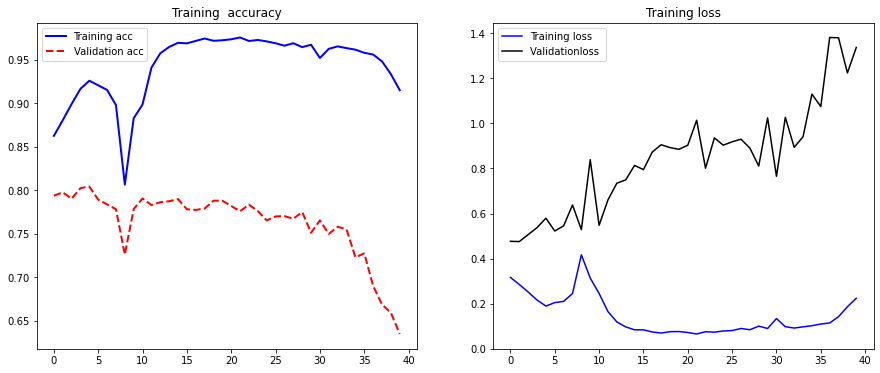

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc',linewidth=2)
plt.plot(epochs, val_acc, 'r--', label='Validation acc',linewidth=2)
plt.title('Training  accuracy')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'b', label='Training loss')

plt.plot(epochs, val_loss, 'k', label='Validationloss ')
plt.title('Training loss')
plt.legend()

plt.show()

In [50]:
##################################
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.6

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


IoU socre is:  0.25601737776507033


### Test within known data

dataset/train/asagao/asagao_0001.png dataset/validation/asagao/asagao_mask_0001.png


(<AxesSubplot:title={'center':'Prediction'}>,
 Text(0.5, 1.0, 'Prediction'))

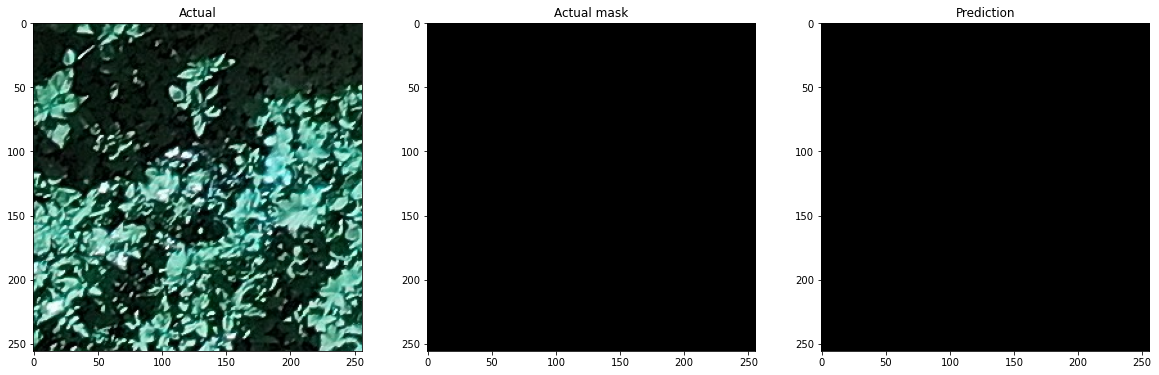

In [55]:
def predict_tile(tile, sens = 0.001):
    tile = tile.astype('float32') / 255.0
    test_img_other_input=np.expand_dims(tile, 0)
    prob_map = (model.predict(test_img_other_input) > sensitivty).astype(np.uint8)
    return prob_map[0]
    

file_name = "asagao_0001.png"
train_file = 'dataset/train/asagao/' + file_name
test_file = 'dataset/validation/asagao/' + file_name.replace("asagao_", "asagao_mask_" )

print(train_file, test_file)
sensitivty = 0.9
test_img_other = cv2.imread(train_file)
r = predict_tile(test_img_other, sensitivty)

plt.figure(figsize=(20,20))
actual = cv2.imread(train_file)
mask = cv2.imread(test_file)
plt.subplot(131),plt.imshow(actual),plt.title("Actual")
plt.subplot(132),plt.imshow(mask),plt.title("Actual mask")
plt.subplot(133),plt.imshow(r, cmap="gray"),plt.title("Prediction")


### Predict with tiled image

##### 1.Slice the image

In [56]:
import os
import os
from tiled_detiled import tiled_image

sensitivity = 0.04
target_f = "dataset/raw/not_labeled/30m-1/DJI_20211208095102_0006.JPG"

if len(os.listdir('dataset/test/test1')) != 0:
    print("Found previous tiled images, attemp delete")
    file_to_delete = os.listdir('dataset/test/test1')
    for f in file_to_delete:
        os.remove('dataset/test/test1/' + f)

target_im = cv2.imread(target_f)
if target_im is not None:
    tiled_image(target_im, 256, "dataset/test/test1")
else:
    print("Cannot read ifle")


#Slice image
predict_file = sorted(glob("dataset/test/test1/*.png"))
predict_file = iter(predict_file)
# print(predict_file)

predicted_list = []

#remove existing file
if len(os.listdir('dataset/test/result_test1')) != 0:
    print("Found previous predicted files, attemp delete")
    file_to_delete = os.listdir('dataset/test/result_test1')
    for f in file_to_delete:
        os.remove('dataset/test/result_test1/' + f)
#predict slided image
nn = 1
for f in predict_file:
    target = f
    # print(target)
    inputs = cv2.imread(target)
    r = predict_tile(inputs, sensitivity)
    tf.keras.preprocessing.image.save_img('dataset/test/result_test1/result_%s.png'% str(nn).zfill(4),r)
    nn += 1

#save otuput
from glob import glob
import math
result_heigth = 5460
result_width = 8192
tile_size = 256


file = sorted(glob("dataset/test/result_test1/*"))

temp = np.zeros((math.ceil(result_heigth / tile_size) * tile_size, math.ceil(result_width / tile_size) * tile_size,3))

i = 0
for r in range(0, temp.shape[0], tile_size):
    for c in range(0, temp.shape[1], tile_size):
        tile = cv2.imread(file[i])
        temp[r:r + tile_size, c:c + tile_size,:] = tile 
        i += 1

cv2.imwrite("predicted_location.jpg" , temp[:5460, :8192,:])
# cv2.imwrite("predicted_location_DJI_20211208095147_0040.JPG" , temp[:5460, :8192,:])


True

In [ ]:
def convert_bw(img):
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bw = cv2.threshold(grayImage, thresh, 255, cv2.THRESH_BINARY)[1]
    image_bw = Image.fromarray(bw)
    return image_bw

_ground_truth = cv2.imread("actual_location_DJI_20211208095102_0006_LABELED.jpg")
_pred = cv2.imread("predicted_location.jpg")

gt = convert_bw(_ground_truth)
pd = convert_bw(_pred)


intersection = np.logical_and(gt, pd)
union = np.logical_or(gt, pd)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

